# 1.Fuction import

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cmocean.cm as cm
import matplotlib.pyplot as plt
import matplotlib.path as mpath
# from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner as gridliner
import datetime
import calendar 
import sys
import os
import glob
import gsw
import json
# Add the current directory to the system path
sys.path.append('/g/data/jk72/zc0441')
from zpackage import wmt
from zpackage.zclef import Zlook


In [2]:
# model = 'ACCESS-CM2' 		 ## 'ACCESS-CM2' 'ACCESS-ESM1-5' 'CAS-ESM2-0' 'CanESM5' 'FIO-ESM-2-0' 'CNRM-CM6-1' 'FGOALS-g3' 'IPSL-CM6A-LR' 'CMCC-CM2-HR4' 'EC-Earth3'
variable_list = ['tos', 'sos', 'hfds', 'wfo' ,'vmo', 'so' ,'thetao']
frequency = 'mon'
experiment = 'historical'
member_id = 'r1i1p1f1'
realm = 'ocean'

yrst = '1990'; yren = '2009'
lat_edge = -45

figure_plot_trigger = True
file_path = '/g/data/jk72/zc0441/Subject_1/model_list.json'
fig_path = '/g/data/jk72/zc0441/Figures/20230626/'

# Load the avaliable model
with open(file_path, 'r') as file:
    model_list = json.load(file)

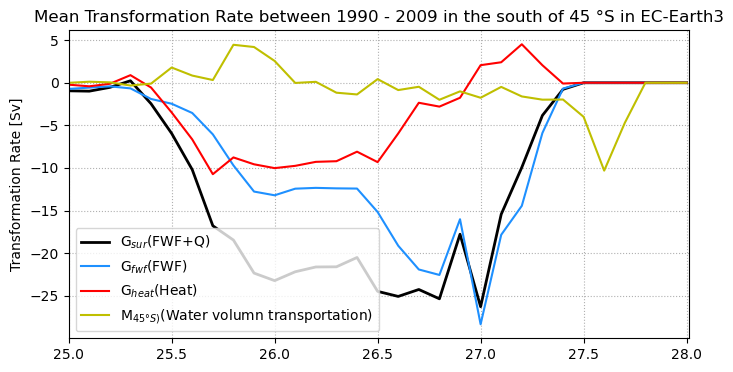

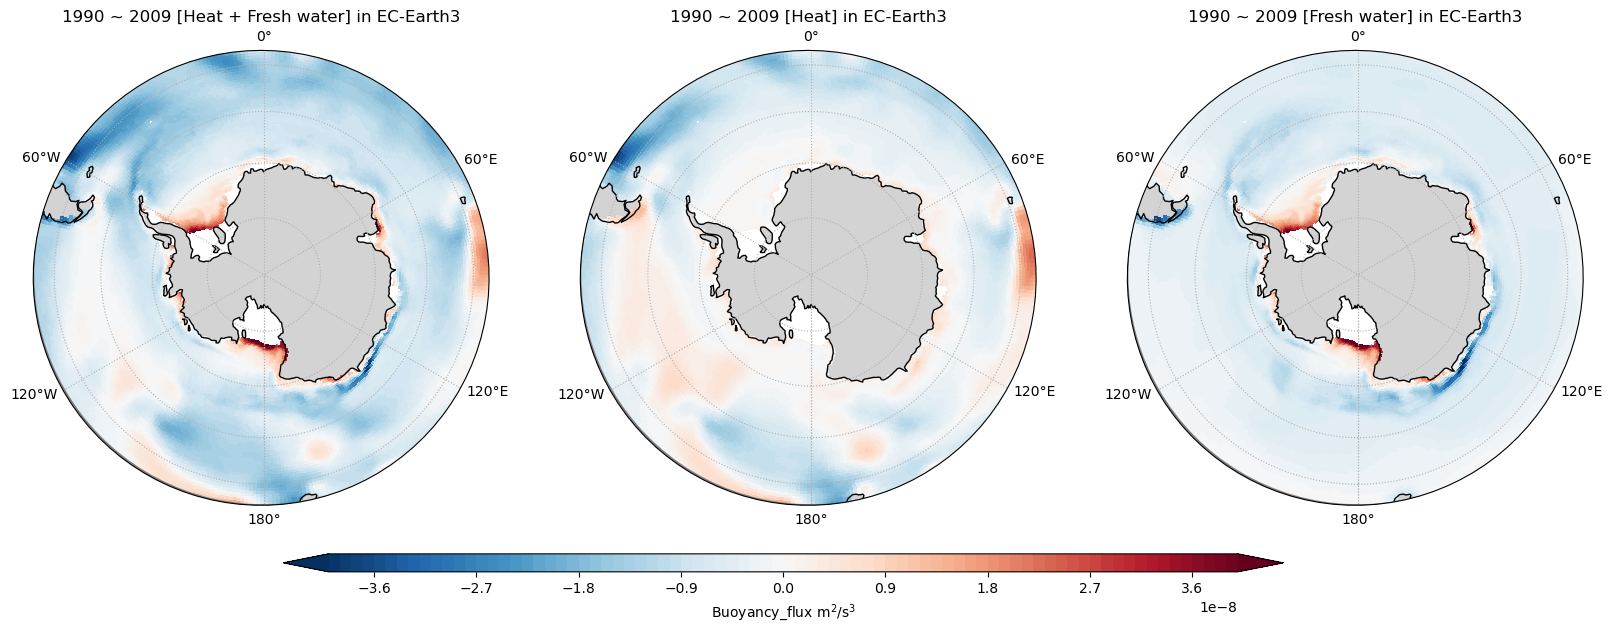

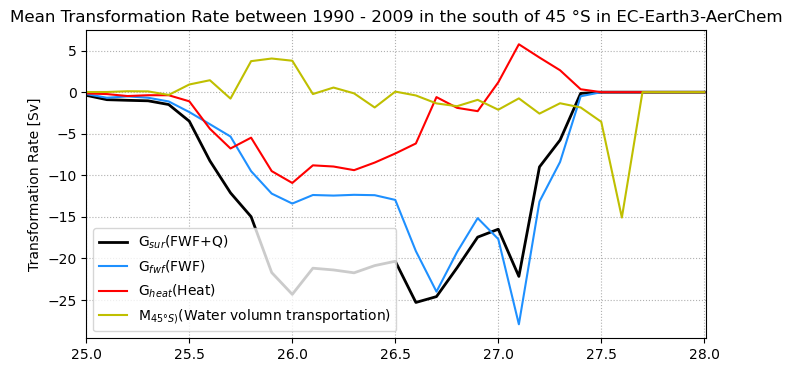

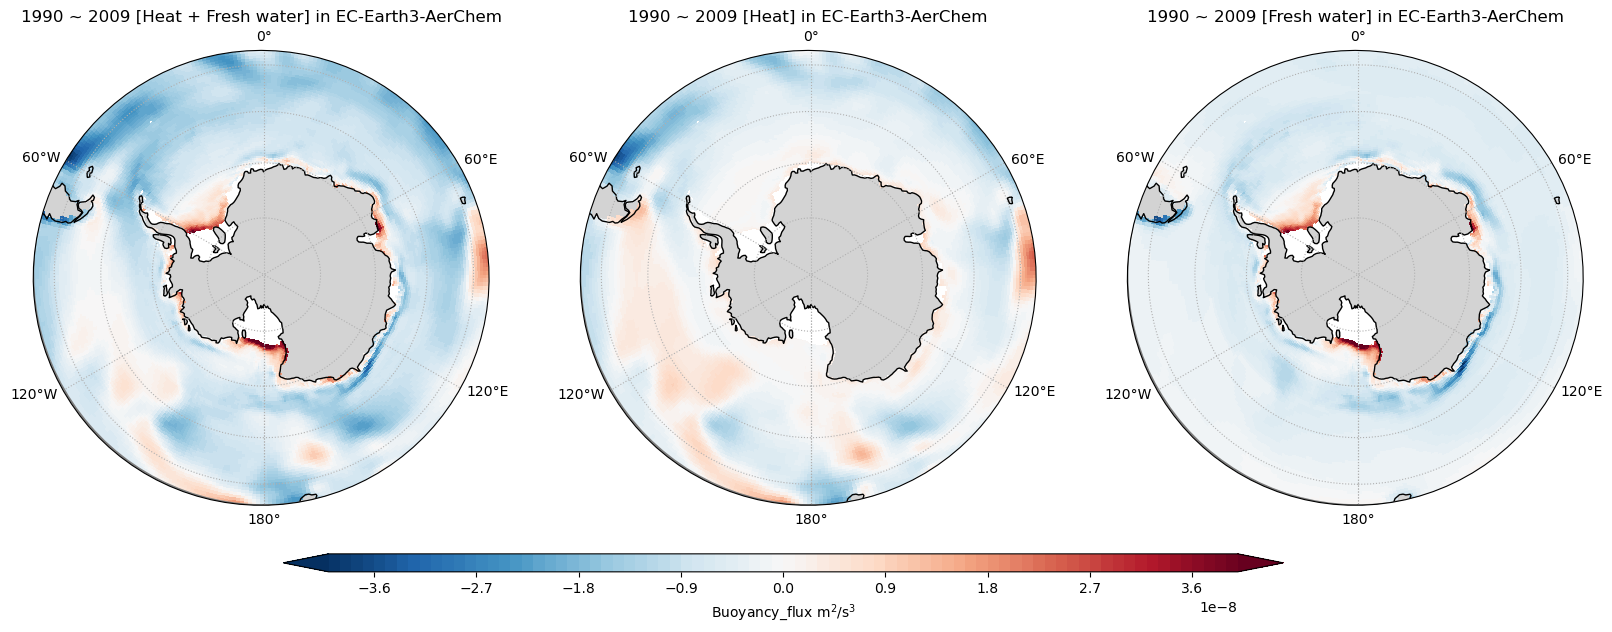

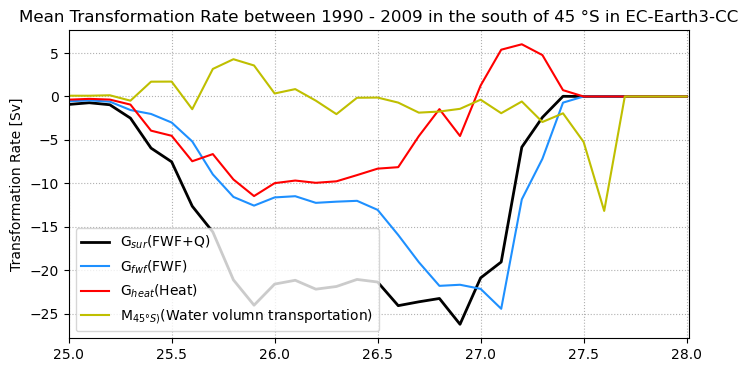

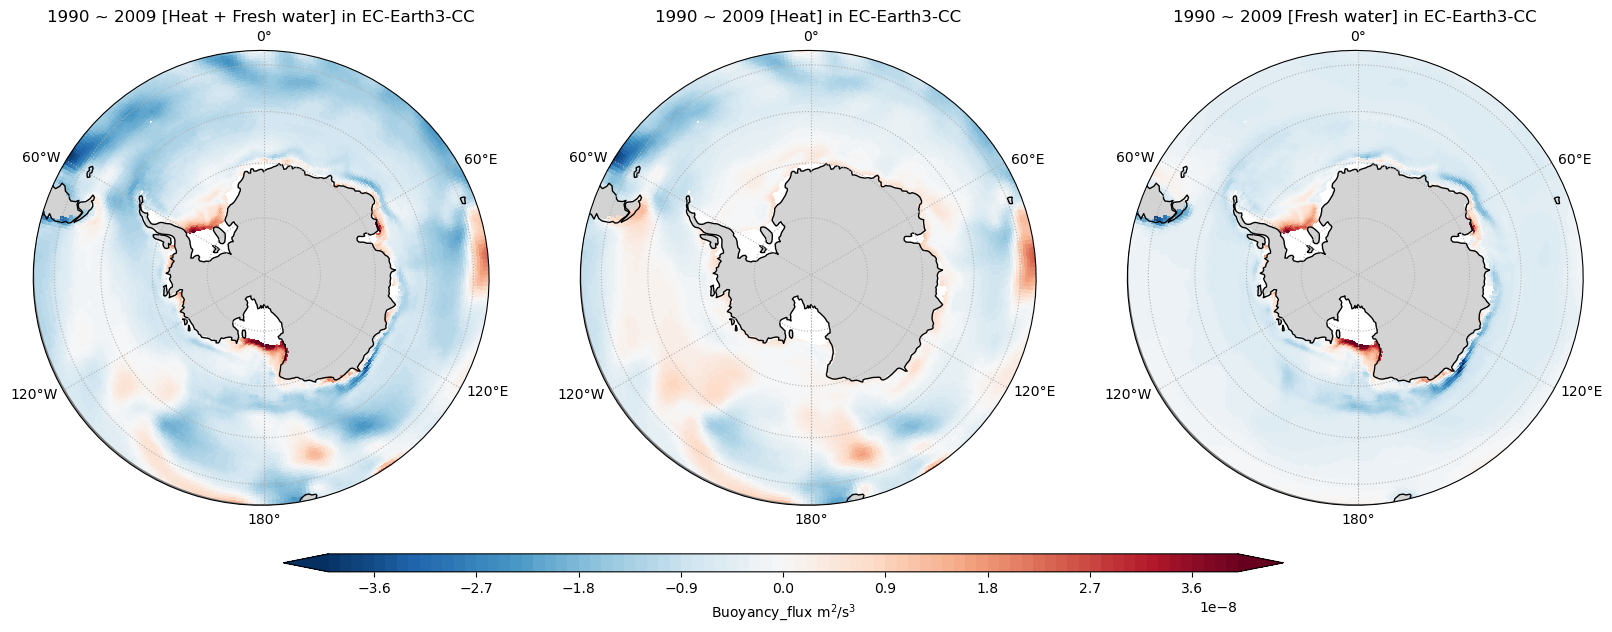

KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

In [11]:
for model in model_list[9:17]:
    # Load data of each variables
    df_ga = Zlook({'variable': 'areacello', 'model': model, 'experiment': experiment}) # The sea grid area 
    resolution = df_ga.show().nominal_resolution[0]
    variant_label = sorted(df_ga.show().variant_label.values, key=lambda x: int(x[1:x.index('i')]))[0]
    
    df_list = []
    for variable in variable_list:
        df = Zlook({'variable': variable, 'model': model, 'f': frequency, 'experiment': experiment, 'realm': realm , 'nominal_resolution': resolution, 'variant_label': variant_label}) # , 'mi' : member_id}
        df_list.append(df)
     
    
    tem = df_list[0].smart_open(df_list[0].path(), int(yrst), int(yren))
    sal = df_list[1].smart_open(df_list[1].path(), int(yrst), int(yren))
    hf = df_list[2].smart_open(df_list[2].path(), int(yrst), int(yren))
    fwf = df_list[3].smart_open(df_list[3].path(), int(yrst), int(yren))
    mty = df_list[4].smart_open(df_list[4].path(), int(yrst), int(yren))
    pre =xr.zeros_like(hf)
    grid_area = xr.open_dataset(df_ga.kw_search(df_ga.path(),'1')[0])[df_ga.v()]

    ## Find the coord key
    dim_list = list(mty.dims)+ list(mty.coords.keys())
    lat_key = None
    lon_key = None
    lat_keys = ['latitude', 'lat', 'nav_lat']
    lon_keys = ['longitude', 'lon', 'nav_lon']
    j_keys = ['y','j']
    for key in dim_list:

        if key in lat_keys:
            lat_key = key
        if key in lon_keys:
            lon_key = key
        if key in j_keys:
            j_key = key

    # Search the grid along the selected latitude boundary
    latitude = mty[lat_key].values
    nearest_index = np.abs(latitude - lat_edge).argmin(axis=0)
    if isinstance(nearest_index, np.ndarray): # In case the nearest_index is a list
        nearest_index = nearest_index[0]

    # Select the salinity and temperature along the selected latitude
    sal_ver = df_list[5].smart_open(df_list[5].path(), int(yrst), int(yren)).sel(**{j_key : nearest_index}).mean('time')
    tem_ver = df_list[6].smart_open(df_list[6].path(), int(yrst), int(yren)).sel(**{j_key : nearest_index}).mean('time')
    pre_ver = xr.zeros_like(tem_ver)

    # calculate the total transportation within the boundary
    mt = mty.sel(**{j_key : nearest_index}).mean('time').compute()
    den_ver = gsw.rho(sal_ver,tem_ver,pre_ver).compute()
    tr = mt/den_ver
    
    # The heat flux and freshwater flux direction check
    hf_dir_check_sample = hf.sel(time = yrst + '-07').where(hf[lat_key]>30).mean()
    fwf_dir_check_sample = fwf.sel(time = yrst + '-07').where(fwf[lat_key]>50).mean()

    if hf_dir_check_sample < 0:
        hf = -hf
    if fwf_dir_check_sample < 0:
        fwf = -fwf
        
    # Variable mean
    hf_mean = hf.mean('time').compute()
    fwf_mean = fwf.mean('time').compute()
    sal_mean = sal.mean('time').compute()
    tem_mean = tem.mean('time').compute()
    pre_mean = xr.zeros_like(hf_mean)
    density_mean = gsw.rho(sal_mean, tem_mean, pre_mean)

    tr_heat_weighted = wmt.trans_rate_heat(hf_mean, sal_mean, tem_mean, pre_mean) * grid_area
    tr_fwf_weighted = wmt.trans_rate_water(fwf_mean, sal_mean, tem_mean, pre_mean) * grid_area

    # Data sortation by density range 
    tr_list_all = [] ; tr_list_hf = [] ; tr_list_fwf= [] ; tr_list_tran = [] ; 
    tr_list_mix = []
    x_lim = [25,28.01]
    interval = 0.1  # Set the interval for the water mass transformation
    sverdrop = 10**6 # Unit for severdrop 10^6 m^3/s
    density_range =  np.arange(x_lim[0], x_lim[1], interval) 
    density_applied = density_mean.where(density_mean[lat_key]<lat_edge) # sift the density range

    for den in density_range:
        den_left = 1000 + den - interval/2; den_right = 1000 + den + interval/2 # the right and left density boundary 

        #====Here the density difference is setted as half interval 
        den_dif = interval
        tr_hf = tr_heat_weighted.where(density_applied > den_left).where(density_applied < den_right) / den_dif  / sverdrop
        tr_fwf = tr_fwf_weighted.where(density_applied > den_left).where(density_applied < den_right)  / den_dif / sverdrop
        tr_tran = tr.where(den_ver> den_left).where(den_ver<den_right)  / sverdrop

        hf_all = tr_hf.sum().values.item()
        fwf_all = tr_fwf.sum().values.item()
        tran_all = tr_tran.sum().values.item()

        tr_list_all.append(hf_all+fwf_all)
        tr_list_hf.append(hf_all)
        tr_list_fwf.append(fwf_all)
        tr_list_tran.append(tran_all)
        tr_list_mix.append(tran_all - hf_all - fwf_all)
        
        
    # Plot of the tansformation rate 
    fig_title = f'Mean Transformation Rate between {yrst} - {yren} in the south of {str(abs(lat_edge))} °S in {model}'

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

    ax = axs
    ax.plot(density_range, tr_list_all, label='G$_{sur}$(FWF+Q)',linewidth=2, color = 'black')
    ax.plot(density_range, tr_list_fwf, label='G$_{fwf}$(FWF)',color = 'dodgerblue')
    ax.plot(density_range, tr_list_hf, label='G$_{heat}$(Heat)',color = 'r')
    ax.plot(density_range, tr_list_tran, label='M$_{45°S)}$(Water volumn transportation)',color = 'y')
    # ax.plot(density_range, tr_list_mix, label='Mixing',color = 'g')

    # Add a legend
    ax.legend()

    # Add a grid
    ax.grid(linestyle = ':')

    # Set the x and y axis labels
    # ax.set_xlabel('Density Range')
    ax.set_ylabel('Transformation Rate [Sv]')
    ax.set_title(fig_title)
    ax.set_xlim(x_lim)
    # ax.set_ylim(-30,30)
    if figure_plot_trigger:
        fig.savefig(fig_path + model +'.png')

    ## 3.5 Transformation rate plot

    # buo, buo_hf, buo_fwf = wmt.buoyancy_flux(hf, fwf, sal, tem, pre, formula='default') 
    buo, buo_hf, buo_fwf = wmt.buoyancy_flux(hf.compute(), fwf.compute(), sal.compute(), tem.compute(), pre.compute(), formula='default') 

    lat_edge = -45

    buo_year = buo.where(buo[lat_key]<lat_edge).mean('time')
    buo_hf_year = buo_hf.where(buo[lat_key]<lat_edge).mean('time')
    buo_fwf_year = buo_fwf.where(buo[lat_key]<lat_edge).mean('time')

    data_list = [buo_year, buo_hf_year, buo_fwf_year]
    title_list = [' [Heat + Fresh water]' , ' [Heat]', ' [Fresh water]']

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 12),
                            subplot_kw=dict(projection=ccrs.Orthographic(0, -90)) #,facecolor="gray"
                           )

    for index, data in enumerate(data_list):

        fig1 = data.plot(x = lon_key,y = lat_key,
                        transform=ccrs.PlateCarree(),
                        levels = np.arange(-4e-8, 4.01e-8, 1e-9), 
                        add_colorbar=False,
                        ax = axs[index]
                        )
        ax = axs[index]
        ax.coastlines()
        ax.gridlines(linestyle = ':',draw_labels=True)
        ax.set_extent([-180, 180, -90, lat_edge], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.set_title( yrst + ' ~ ' + yren + title_list[index] + ' in ' + model) 

        # Add solid line at 50°S latitude
        # Plot the line segment
        lon = np.linspace(-180, 180, 100)
        lat = np.full_like(lon, lat_edge)
        ax.plot(lon, lat, color='gray', linestyle='-', transform=ccrs.PlateCarree())
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)

    cbar = fig.colorbar(fig1, ax=axs.ravel().tolist(), 
                        cax=fig.add_axes([0.25, 0.25, 0.5, 0.015]),
                        orientation = 'horizontal',
                       )
    cbar.set_label(buo.standard_name + ' ' + buo.units)

    # plt.tight_layout()
    plt.show()
    if figure_plot_trigger:
        fig.savefig(fig_path + '1buo_' + model +'.png')

In [4]:
model

'CNRM-ESM2-1'

In [5]:
resolution

'100 km'

In [6]:
df_ga.show()

,project,activity_id,institution_id,source_id,source_type,experiment_id,sub_experiment_id,frequency,realm,variant_label,...,nominal_resolution,table_id,version,variable,path,filename,periods,fdate,tdate,time_complete
path,,,,,,,,,,,,,,,,,,,,,
/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Ofx/areacello/gn/v20181206,CMIP6,CMIP,CNRM-CERFACS,CNRM-ESM2-1,AOGCM BGC AER CHEM,historical,none,fx,ocean,r1i1p1f2,...,100 km,Ofx,v20181206,areacello,/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/...,{areacello_Ofx_CNRM-ESM2-1_historical_r1i1p1f2...,[],None,None,None
/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r2i1p1f2/Ofx/areacello/gn/v20190125,CMIP6,CMIP,CNRM-CERFACS,CNRM-ESM2-1,AOGCM BGC AER CHEM,historical,none,fx,ocean,r2i1p1f2,...,100 km,Ofx,v20190125,areacello,/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/...,{areacello_Ofx_CNRM-ESM2-1_historical_r2i1p1f2...,[],None,None,None
/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r3i1p1f2/Ofx/areacello/gn/v20190125,CMIP6,CMIP,CNRM-CERFACS,CNRM-ESM2-1,AOGCM BGC AER CHEM,historical,none,fx,ocean,r3i1p1f2,...,100 km,Ofx,v20190125,areacello,/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/...,{areacello_Ofx_CNRM-ESM2-1_historical_r3i1p1f2...,[],None,None,None
/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r4i1p1f2/Ofx/areacello/gn/v20190125,CMIP6,CMIP,CNRM-CERFACS,CNRM-ESM2-1,AOGCM BGC AER CHEM,historical,none,fx,ocean,r4i1p1f2,...,100 km,Ofx,v20190125,areacello,/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/...,{areacello_Ofx_CNRM-ESM2-1_historical_r4i1p1f2...,[],None,None,None
/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r5i1p1f2/Ofx/areacello/gn/v20190125,CMIP6,CMIP,CNRM-CERFACS,CNRM-ESM2-1,AOGCM BGC AER CHEM,historical,none,fx,ocean,r5i1p1f2,...,100 km,Ofx,v20190125,areacello,/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/...,{areacello_Ofx_CNRM-ESM2-1_historical_r5i1p1f2...,[],None,None,None
/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r10i1p1f2/Ofx/areacello/gn/v20200117,CMIP6,CMIP,CNRM-CERFACS,CNRM-ESM2-1,AOGCM BGC AER CHEM,historical,none,fx,ocean,r10i1p1f2,...,100 km,Ofx,v20200117,areacello,/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/...,{areacello_Ofx_CNRM-ESM2-1_historical_r10i1p1f...,[],None,None,None
/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r6i1p1f2/Ofx/areacello/gn/v20200117,CMIP6,CMIP,CNRM-CERFACS,CNRM-ESM2-1,AOGCM BGC AER CHEM,historical,none,fx,ocean,r6i1p1f2,...,100 km,Ofx,v20200117,areacello,/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/...,{areacello_Ofx_CNRM-ESM2-1_historical_r6i1p1f2...,[],None,None,None
/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r8i1p1f2/Ofx/areacello/gn/v20200117,CMIP6,CMIP,CNRM-CERFACS,CNRM-ESM2-1,AOGCM BGC AER CHEM,historical,none,fx,ocean,r8i1p1f2,...,100 km,Ofx,v20200117,areacello,/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/...,{areacello_Ofx_CNRM-ESM2-1_historical_r8i1p1f2...,[],None,None,None
/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r9i1p1f2/Ofx/areacello/gn/v20200117,CMIP6,CMIP,CNRM-CERFACS,CNRM-ESM2-1,AOGCM BGC AER CHEM,historical,none,fx,ocean,r9i1p1f2,...,100 km,Ofx,v20200117,areacello,/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/...,{areacello_Ofx_CNRM-ESM2-1_historical_r9i1p1f2...,[],None,None,None


In [7]:
df_list[0].show()

,project,activity_id,institution_id,source_id,source_type,experiment_id,sub_experiment_id,frequency,realm,variant_label,...,nominal_resolution,table_id,version,variable,path,filename,periods,fdate,tdate,time_complete
path,,,,,,,,,,,,,,,,,,,,,
/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Omon/tos/gn/v20181206,CMIP6,CMIP,CNRM-CERFACS,CNRM-ESM2-1,AOGCM BGC AER CHEM,historical,none,mon,ocean,r1i1p1f2,...,100 km,Omon,v20181206,tos,/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/...,{tos_Omon_CNRM-ESM2-1_historical_r1i1p1f2_gn_1...,"[(18500101, 20141231)]",18500101,20141231,True


In [8]:
q1[0][0][23].latitude.values

NameError: name 'q1' is not defined

In [ ]:
q1.sel(**{'y' : 20 })
mty.coords.keys()

In [ ]:
list(q1.dims)+ list(mty.coords.keys())

In [ ]:
nearest_index = np.abs(latitude - lat_edge).argmin(axis=0)
nearest_index

In [ ]:
constraint = {'variable': 'so', 'model': model, 'f': frequency, 'experiment': experiment} # The surface temperture including temperatures below sea-ice and floating ice shelves. 
df = Zlook(constraint)
df.show()
xr.open_dataset(df.kw_search(df.path(),'1')[0])[df.v()]

In [ ]:
#     constraint1 = {'variable': 'tos', 'model': model, 'f': frequency, 'experiment': experiment, 'mi' : member_id} # The surface temperture including temperatures below sea-ice and floating ice shelves. 
#     df1 = Zlook(constraint1)

#     constraint3 = {'variable': 'sos', 'model': model, 'f': frequency, 'experiment': experiment, 'mi' : member_id} # The surface salinity
#     df3 = Zlook(constraint3)

#     constraint4 = {'variable': 'hfds', 'model': model, 'f': frequency, 'experiment': experiment, 'mi' : member_id} # The heat flux
#     df4 = Zlook(constraint4)

#     constraint5 = {'variable': 'wfo', 'model': model, 'f': frequency, 'experiment': experiment, 'mi' : member_id} # The waterflux into ocean
#     df5 = Zlook(constraint5)

#     constraint6 = {'variable': 'areacello', 'model': model, 'experiment': experiment} # The sea grid area 
#     df_ga = Zlook(constraint6)

#     constraint8 = {'variable': 'vmo', 'model': model, 'f': frequency, 'experiment': experiment, 'mi' : member_id} # The Mass transport along Y 
#     df8 = Zlook(constraint8)

#     constraint9 = {'variable': 'so', 'model': model, 'f': frequency, 'experiment': experiment, 'mi' : member_id} # Salinity
#     df_list[5] = Zlook(constraint9)

#     constraint10 = {'variable': 'thetao', 'model': model, 'f': frequency, 'experiment': experiment, 'mi' : member_id} # temperatrue
#     df10 = Zlook(constraint10)